In [1]:
%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

if sys.version_info[0] ==3:
    import pickle
else:
    import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT, SRWLOptMirPl, SRWLOptCryst

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import Drift, Aperture, Lens,Mirror_elliptical, WF_dist, calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

plt.ion()

In [3]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011

    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def _save_object(obj, file_name):
    """
    Save any python object to file.

    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'wb') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.

    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'rb') as f:
        res = pickle.load(f)

    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise


# Outline

1. Flat mirror with increasingly bad errors
2. Focusing the reflected beams, and adding square aperture between mirror and lens
3. Custom OE: lens/prism array
4. asymmetric crystal reflection and focusing, assuming 2 Gaussian pulse of slightly different photon energies
5. SASE

### Defining initial wavefront and writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483
save hdf5: g6_742kev.h5
done
FWHMx [mm]: 0.70276295188322
FWHMy [mm]: 0.70276295188322
Coordinates of center, [mm]: -0.0005236683695106648 -0.0005236683695106648
stepX, stepY [um]: 1.0473367390211923 1.0473367390211923 

Total power (integrated over full range): 9.79805 [GW]
Peak power calculated using FWHM:         9.79246 [GW]
Max irradiance: 17.4273 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.70276295188322, 2.9904806463115747


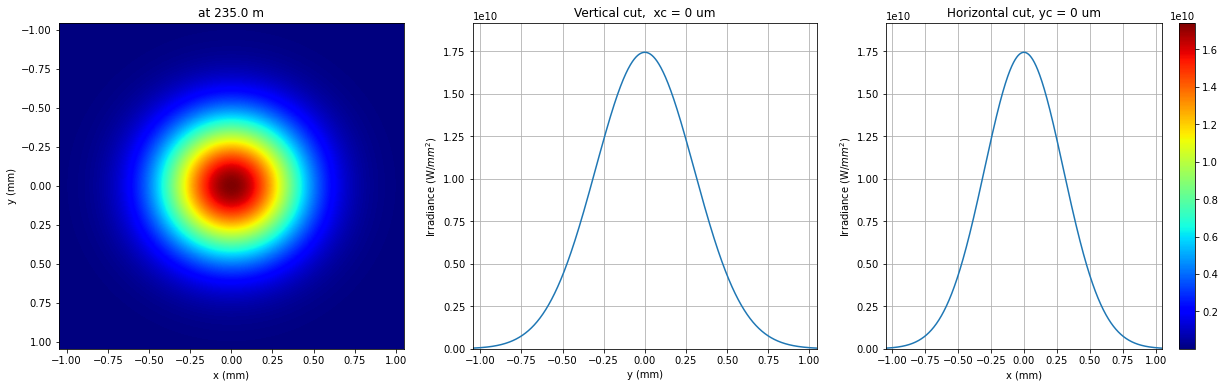

In [4]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
#pulse_duration = 9.e-15;
pulse_duration = 50.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = 0.24e-15

''' distance to first OE '''
z1 = 235.0

theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size

''' input dimensions '''
npoints=2000

wfr0 = build_gauss_wavefront_xy(npoints, npoints, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX, sigX, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/np.sqrt(2),
                                repRate=1/(np.sqrt(2)*pulse_duration))

mwf = Wavefront(wfr0)
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname0 = 'g' + ename
ifname = os.path.join(strDataFolderName,fname0+'.h5')
print('save hdf5: '+fname0+'.h5')
mwf.store_hdf5(ifname)
print('done')

pow_x=plot_wfront(mwf, 'at '+str(z1)+' m',False, False, 1e-5,1e-5,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('jet') #set color map, 'bone', 'hot', 'jet', etc
plt.colorbar()
plt.savefig('WPG_Plots/Gaussian beam source.png',transparent=True)
fwhm_x = calculate_fwhm_x(mwf);fwhm_y = calculate_fwhm_y(mwf)
print('FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: {}, {}'.format(
        fwhm_x*1e3,fwhm_x/z1*1e6)
      )

mwf_backup = mwf

In [5]:
print(pow_x[:,1].max())
print ('I_o {} [GW/mm^2]'.format((pow_x[:,1].max()*1e-9)))
print ('peak power {} [GW]'.format((pow_x[:,1].max()*1e-9*1e6*2*np.pi*(fwhm_x/2.35)**2)))

print('{} slices'.format(mwf.params.Mesh.nSlices))

17427292160.0
I_o 17.42729216 [GW/mm^2]
peak power 9.79245924084223 [GW]
1 slices


### 1. Flat mirror with increasingly bad errors

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.00025
		xStart = -0.00025
		yFin = 0.00025
		yStart = -0.00025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 1
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  2000  range_x [-1.0e+00, 1.0e+00] mm
ny  2000  range_y [-1.0e+00, 1.0e+00] mm
*****propagating wavefront (with resizing)...
done
propagation lasted: 0.1 min
R-space
R-space


Text(0, 0.5, 'y (mm)')

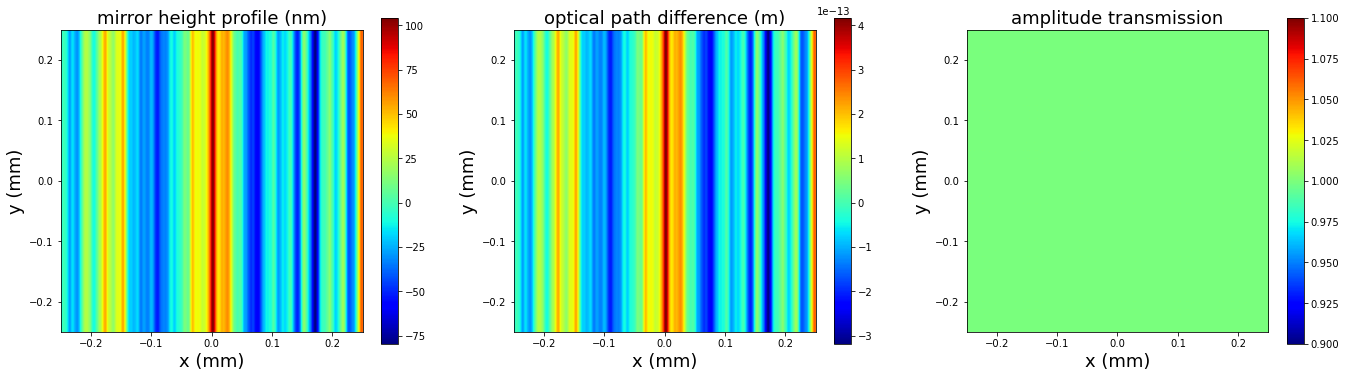

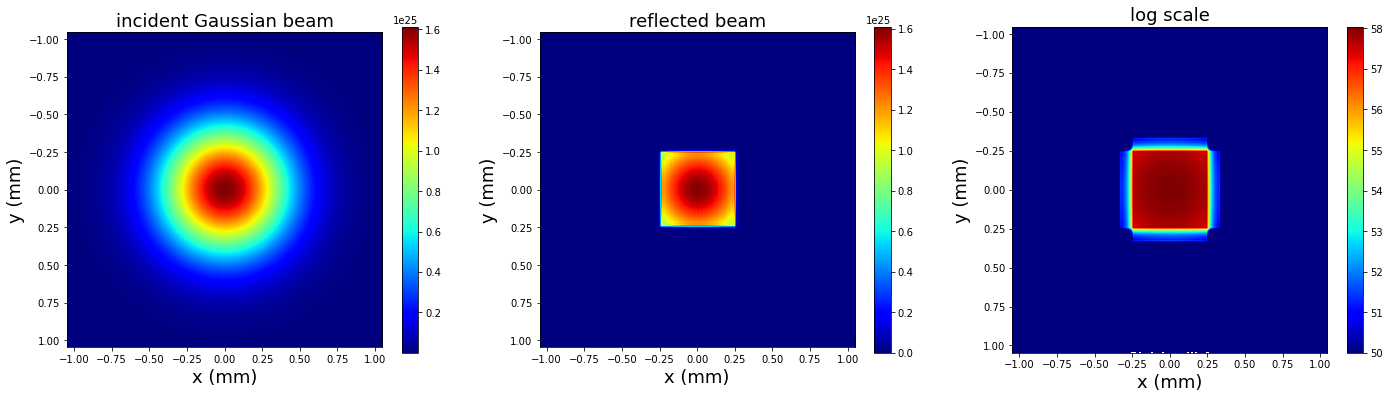

In [6]:
%autoreload 2
from Optics import *

''' sampling parameters '''
E = ekev*1000
Mirror_width = 0.5e-3      # physical size of Mirror aperture

nx = 2000; ny = nx     # number of points in H and V

# initialize Mirror container
Mirror_Apt = SRWLOptA('r','a',Mirror_width,Mirror_width)
#Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)  # Fx given if lens
Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_x=0,_y=0,_eStart=E,_eFin=E)              # Fx not given if aperture

Mirror_x = np.linspace(-Mirror_width/2,Mirror_width/2,nx)
Mirror_y = np.linspace(-Mirror_width/2,Mirror_width/2,ny)
Mirror_x, Mirror_y = np.meshgrid(Mirror_x,Mirror_y)

Mirror_z= Flat_Mirror(Mirror_x,Mirror_y)

''' mirror variable '''
theta = 2e-6
orientation = 'horizontal'

''' mirror error '''
mir_x = np.loadtxt('mirror1.dat')[:,0]
mir_z = np.loadtxt('mirror1.dat')[:,1]
err = np.interp(Mirror_x[0]*0.5/Mirror_width,mir_x,mir_z)

err = np.repeat([err],2000,axis=0)
if orientation == 'vertical':
    err = err.T

Mirror_z = Flat_Mirror(Mirror_x, Mirror_y)
Mirror_z += err * 100

Calc_OPD_and_AmpTr_Mirror(Mirror_Tr, Mirror_z, theta)

OPD_show = np.array(Mirror_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Mirror_Tr.arTr)[0::2].reshape(ny,nx)

''' plot mirror '''
# plot transmission and OPD
xlimi = -Mirror_width/2; xlimf = Mirror_width/2
ylimi = -Mirror_width/2; ylimf = Mirror_width/2

plt.figure(figsize=(23,6))
plt.subplot(1,3,1)
plt.imshow(Mirror_z*1e9,cmap='jet',
          extent=[xlimi*1e3,xlimf*1e3,ylimi*1e3,ylimf*1e3])
plt.colorbar()
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.title('mirror height profile (nm)',fontsize=18)

OPD_show = np.array(Mirror_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Mirror_Tr.arTr)[0::2].reshape(ny,nx)

plt.subplot(1,3,2)
plt.imshow(
    OPD_show,cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.title('optical path difference (m)',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(
    AmpTr_show,cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
#plt.imshow(AmpTr_show,cmap='jet')
plt.colorbar()
plt.title('amplitude transmission',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

''' propagation '''
z2 = 1
optBL0 = Beamline()
optBL0.append(Mirror_Apt,    Use_PP())
optBL0.append(Mirror_Tr,     Use_PP())
optBL0.append(Drift(z2), Use_PP(semi_analytical_treatment=1))

bl = optBL0
out_file_name = None
startTime = time.time()
mwf_mirror = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' plot '''
# incident beam
[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(mwf_backup.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('incident Gaussian beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

# reflected beam
[xmin, xmax, ymin, ymax] = mwf_mirror.get_limits()
plt.subplot(1,3,2)
plt.imshow(mwf_mirror.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('reflected beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

plt.subplot(1,3,3)
plt.imshow(
    np.log(mwf_mirror.get_intensity(slice_number=0)),cmap='jet',clim=50,
    extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('log scale',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)


### 2. Focusing the reflected beams, and adding square aperture between mirror and lens

Aperture at 237.0m
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.00025
		xStart = -0.00025
		yFin = 0.00025
		yStart = -0.00025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 2.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.02
	Dy = 0.05
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 

Text(0, 0.5, 'y (mm)')

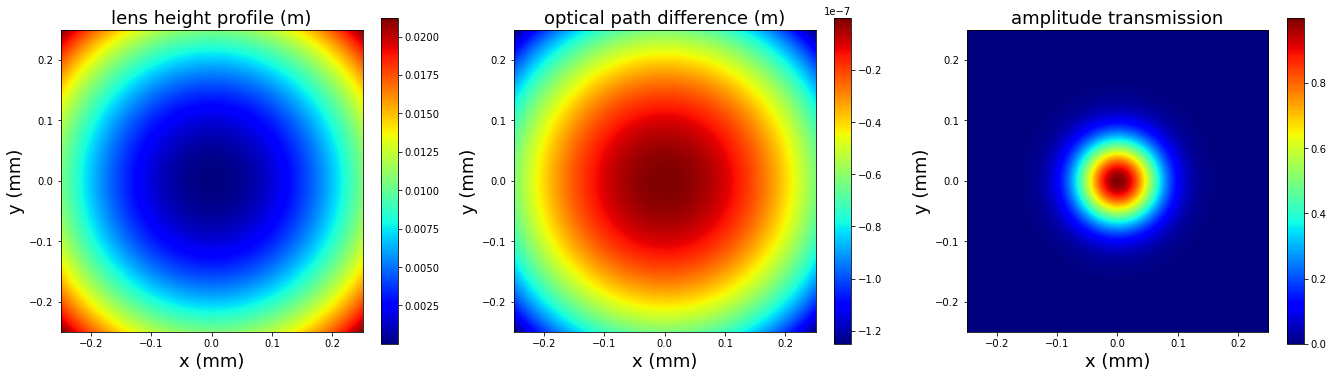

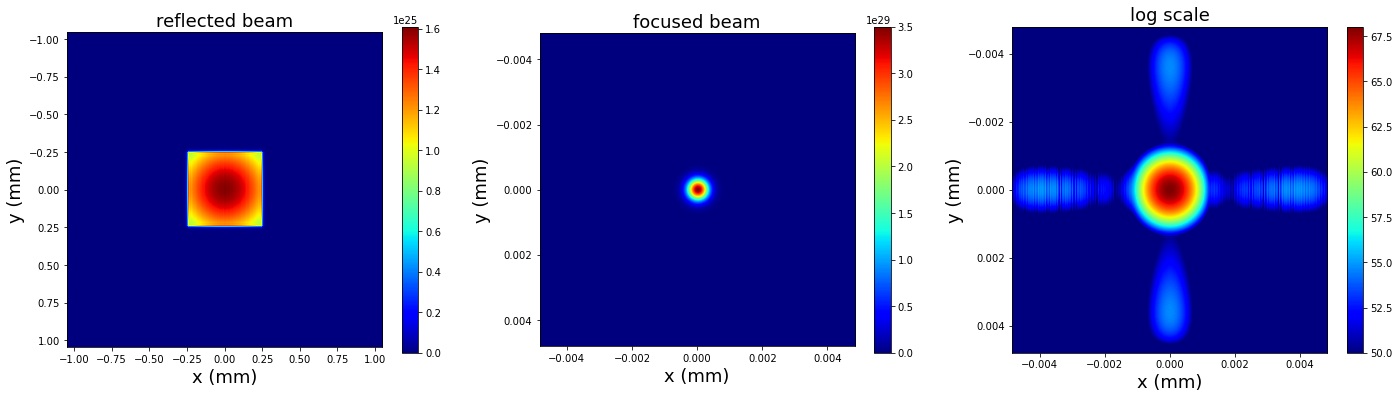

In [7]:
''' Aperture parameter '''
Apt_dx = 20e-3
Apt_dy = 50e-3
z_Apt = 2.0
Apt = SRWLOptA('r','a',Apt_dx,Apt_dy)
print('Aperture at {}m'.format(z1+z_Apt))

''' lens parameter '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth

Lens_width = 0.5e-3
f_lens = 0.5

Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=E,_eFin=E)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

''' plot lens '''
# plot transmission and OPD
xlimi = -Lens_width/2; xlimf = Lens_width/2
ylimi = -Lens_width/2; ylimf = Lens_width/2

plt.figure(figsize=(23,6))
plt.subplot(1,3,1)
plt.imshow(Lens_z,cmap='jet',
          extent=[xlimi*1e3,xlimf*1e3,ylimi*1e3,ylimf*1e3])
plt.colorbar()
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.title('lens height profile (m)',fontsize=18)

OPD_show = np.array(Lens_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Lens_Tr.arTr)[0::2].reshape(ny,nx)

plt.subplot(1,3,2)
plt.imshow(
    OPD_show,cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.title('optical path difference (m)',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(
    AmpTr_show,cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
#plt.imshow(AmpTr_show,cmap='jet')
plt.colorbar()
plt.title('amplitude transmission',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

''' propagation '''
z2 = z_Apt             # propagation distance from mirror to aperture and lens
z3 = f_lens            # propagation distance after lens (to focal plane)
optBL1 = Beamline()
optBL1.append(Mirror_Apt,    Use_PP())
optBL1.append(Mirror_Tr,     Use_PP())
optBL1.append(Drift(z2),     Use_PP(semi_analytical_treatment=1))
optBL1.append(Apt,           Use_PP())
optBL1.append(Lens_Apt,      Use_PP())
optBL1.append(Lens_Tr,       Use_PP())
optBL1.append(Drift(z3),     Use_PP(semi_analytical_treatment=1))

bl = optBL1
out_file_name = None
startTime = time.time()
mwf_lens = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' plot '''
# incident beam
[xmin, xmax, ymin, ymax] = mwf_mirror.get_limits()
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(mwf_mirror.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('reflected beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

# focused beam
[xmin, xmax, ymin, ymax] = mwf_lens.get_limits()
roi_ratio = 0.2
roixi = int(nx*(1-roi_ratio)/2); roixf = int(nx*(1+roi_ratio)/2)
roiyi = int(ny*(1-roi_ratio)/2); roiyf = int(ny*(1+roi_ratio)/2)

xlimi = xmin*roi_ratio; xlimf = xmax*roi_ratio
ylimi = ymin*roi_ratio; ylimf = ymax*roi_ratio

plt.subplot(1,3,2)
plt.imshow(mwf_lens.get_intensity(slice_number=0)[roixi:roixf,roiyi:roiyf],cmap='jet',
          extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar()
plt.title('focused beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

plt.subplot(1,3,3)
plt.imshow(
    np.log(mwf_lens.get_intensity(slice_number=0))[roixi:roixf,roiyi:roiyf],cmap='jet',clim=50,
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('log scale',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)



### 3. Custom OE: lens/prism array

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.00025
		xStart = -0.00025
		yFin = 0.00025
		yStart = -0.00025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.5
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  2000  range_x [-1.0e+00, 1.0e+00] mm
ny  2000  range_y [-1.0e+00, 1.0e+00] mm
*****propagating wavefront (with resizing)...
done
propagation lasted: 0.1 min
R-space
R-space


Text(0, 0.5, 'y (mm)')

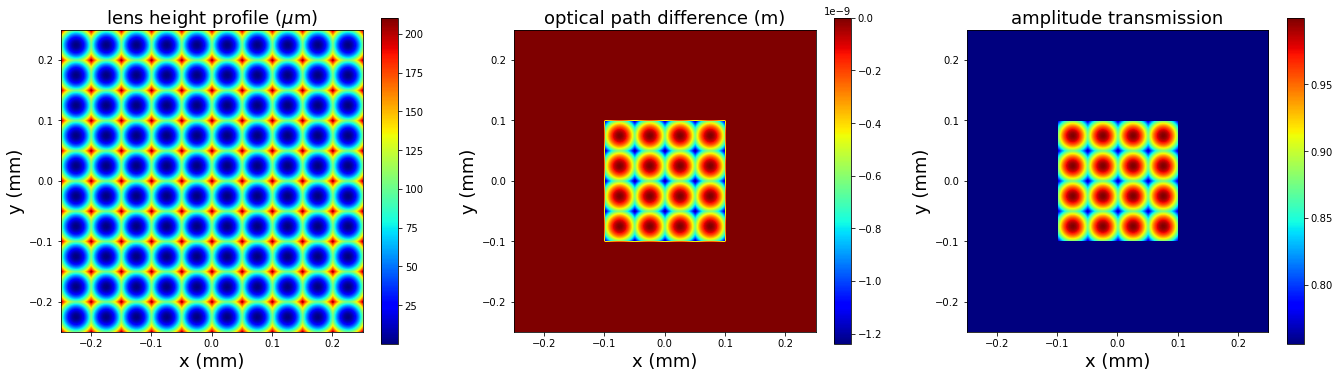

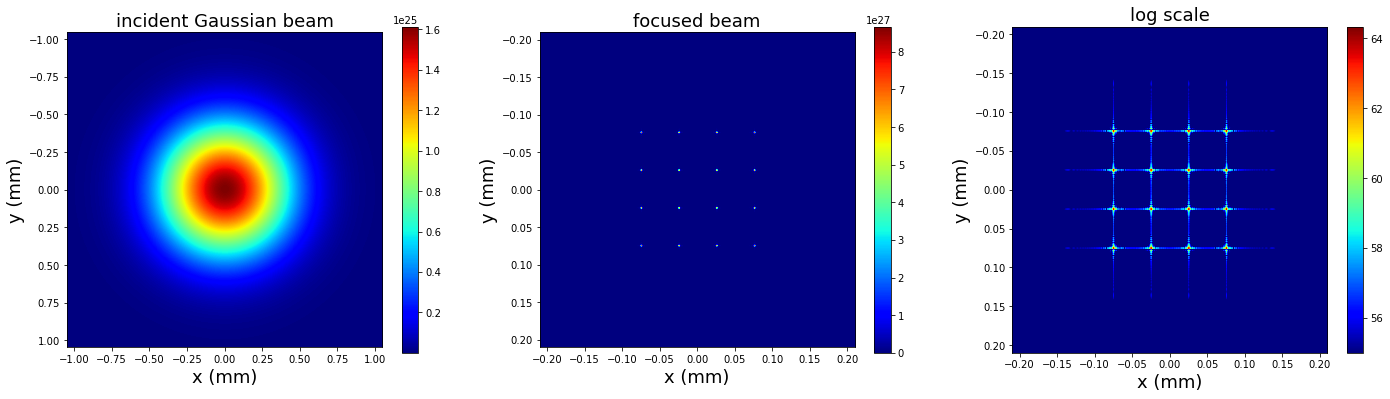

In [8]:
''' Lens Array parameter '''
Lens_Array_width = 0.5e-3
f_lens = 0.5
roix = 4; roiy = 4    # number of lens in each dimension that is installed
# initialize OE container
Lens_Array_Apt = SRWLOptA('r','a',Lens_Array_width,Lens_Array_width)
Lens_Array_Tr = SRWLOptT(nx,ny,Lens_Array_width,Lens_Array_width,
                         _x=0,_y=0,_eStart=E,_eFin=E)

Lens_Array_x = np.linspace(-Lens_Array_width/2,Lens_Array_width/2,nx)
Lens_Array_y = np.linspace(-Lens_Array_width/2,Lens_Array_width/2,ny)
Lens_Array_x, Lens_Array_y = np.meshgrid(Lens_Array_x,Lens_Array_y)

nlx = int(Lens_Array_width/(50e-6)); nly = nlx   # numeber of lens in each dimension over the full axis
if nlx != Lens_Array_width/50e-6:
    print('need integer number of micro lens')

f = f_lens
Lens_Array_z = Perfect_lens_array(Lens_Array_x,Lens_Array_y,n,f,nlx,nly)
Calc_OPD_and_AmpTr(Lens_Array_Tr, Lens_Array_z, n,d_abs,nlx,nly,roix,roiy)

''' plot lens array '''
# plot transmission and OPD
xlimi = -Lens_Array_width/2; xlimf = Lens_Array_width/2
ylimi = -Lens_Array_width/2; ylimf = Lens_Array_width/2

plt.figure(figsize=(23,6))
plt.subplot(1,3,1)
plt.imshow(Lens_Array_z*1e6,cmap='jet',
          extent=[xlimi*1e3,xlimf*1e3,ylimi*1e3,ylimf*1e3])
plt.colorbar()
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.title(r'lens height profile ($\mu$m)',fontsize=18)

OPD_show = np.array(Lens_Array_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Lens_Array_Tr.arTr)[0::2].reshape(ny,nx)

plt.subplot(1,3,2)
plt.imshow(
    OPD_show,cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.title('optical path difference (m)',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(
    AmpTr_show,cmap='jet',clim=AmpTr_show[int(nx/2),int(ny/2)]-0.01,
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
#plt.imshow(AmpTr_show,cmap='jet')
plt.colorbar()
plt.title('amplitude transmission',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

''' propagation '''
z2 = f             # propagation distance from lens array to focal plane
optBL2 = Beamline()
optBL2.append(Lens_Array_Apt,    Use_PP())
optBL2.append(Lens_Array_Tr,     Use_PP())
optBL2.append(Drift(z2),         Use_PP(semi_analytical_treatment=1))

bl = optBL2
out_file_name = None
startTime = time.time()
mwf_lens_array = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' plot '''
# incident beam
[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(mwf_backup.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('incident Gaussian beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

# focused beam
[xmin, xmax, ymin, ymax] = mwf_lens_array.get_limits()
roi_ratio = 0.2
roixi = int(nx*(1-roi_ratio)/2); roixf = int(nx*(1+roi_ratio)/2)
roiyi = int(ny*(1-roi_ratio)/2); roiyf = int(ny*(1+roi_ratio)/2)

xlimi = xmin*roi_ratio; xlimf = xmax*roi_ratio
ylimi = ymin*roi_ratio; ylimf = ymax*roi_ratio

plt.subplot(1,3,2)
plt.imshow(mwf_lens_array.get_intensity(slice_number=0)[roixi:roixf,roiyi:roiyf],cmap='jet',
          extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar()
plt.title('focused beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

plt.subplot(1,3,3)
plt.imshow(
    np.log(mwf_lens_array.get_intensity(slice_number=0))[roixi:roixf,roiyi:roiyf],cmap='jet',clim=55,
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('log scale',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)


Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.00025
		xStart = -0.00025
		yFin = 0.00025
		yStart = -0.00025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.5
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  2000  range_x [-1.0e+00, 1.0e+00] mm
ny  2000  range_y [-1.0e+00, 1.0e+00] mm
*****propagating wavefront (with resizing)...
done
propagation lasted: 0.1 min
R-space
R-space


Text(0, 0.5, 'y (mm)')

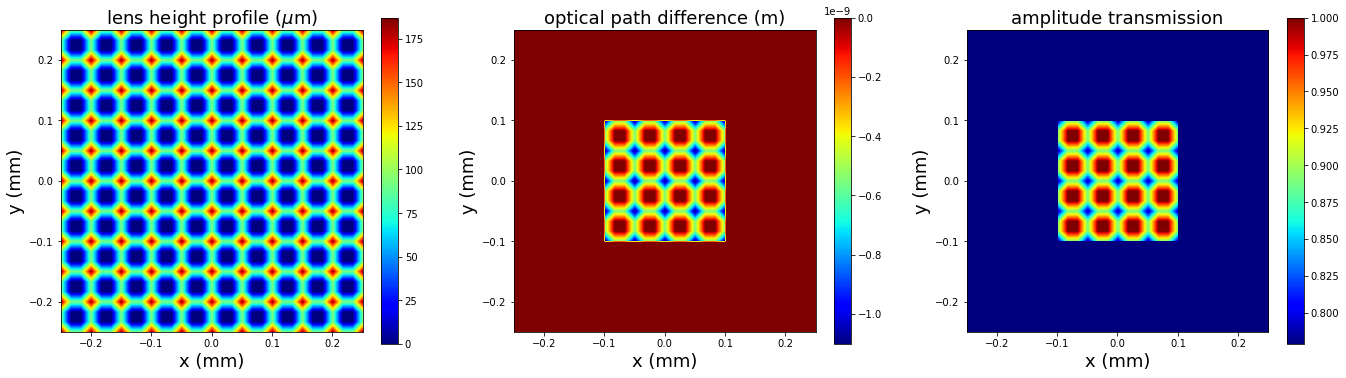

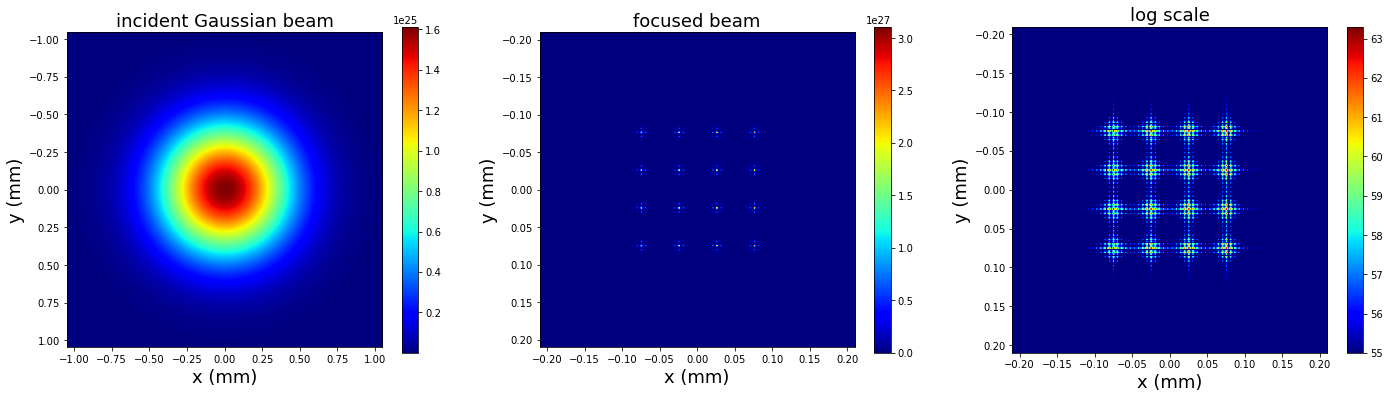

In [9]:
''' Prism Array parameter '''
Prism_Array_width = 0.5e-3
f_prism = 0.5
roix = 4; roiy = 4    # number of lens in each dimension that is installed
# initialize OE container
Prism_Array_Apt = SRWLOptA('r','a',Prism_Array_width,Prism_Array_width)
Prism_Array_Tr = SRWLOptT(nx,ny,Prism_Array_width,Prism_Array_width,
                         _x=0,_y=0,_eStart=E,_eFin=E)

Prism_Array_x = np.linspace(-Prism_Array_width/2,Prism_Array_width/2,nx)
Prism_Array_y = np.linspace(-Prism_Array_width/2,Prism_Array_width/2,ny)
Prism_Array_x, Prism_Array_y = np.meshgrid(Prism_Array_x,Prism_Array_y)

nlx = int(Prism_Array_width/(50e-6)); nly = nlx   # numeber of lens in each dimension over the full axis
if nlx != Prism_Array_width/50e-6:
    print('need integer number of micro lens')

f = f_prism
Prism_Array_z = Prism_array(Prism_Array_x,Prism_Array_y,n,f,nlx,nly)
Calc_OPD_and_AmpTr(Prism_Array_Tr, Prism_Array_z, n,d_abs,nlx,nly,roix,roiy)

''' plot lens array '''
# plot transmission and OPD
xlimi = -Prism_Array_width/2; xlimf = Prism_Array_width/2
ylimi = -Prism_Array_width/2; ylimf = Prism_Array_width/2

plt.figure(figsize=(23,6))
plt.subplot(1,3,1)
plt.imshow(Prism_Array_z*1e6,cmap='jet',
          extent=[xlimi*1e3,xlimf*1e3,ylimi*1e3,ylimf*1e3])
plt.colorbar()
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.title(r'lens height profile ($\mu$m)',fontsize=18)

OPD_show = np.array(Prism_Array_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Prism_Array_Tr.arTr)[0::2].reshape(ny,nx)

plt.subplot(1,3,2)
plt.imshow(
    OPD_show,cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.title('optical path difference (m)',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(
    AmpTr_show,cmap='jet',clim=AmpTr_show[int(nx/2),int(ny/2)]-0.01,
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
#plt.imshow(AmpTr_show,cmap='jet')
plt.colorbar()
plt.title('amplitude transmission',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

''' propagation '''
z2 = f             # propagation distance from lens array to focal plane
optBL3 = Beamline()
optBL3.append(Prism_Array_Apt,    Use_PP())
optBL3.append(Prism_Array_Tr,     Use_PP())
optBL3.append(Drift(z2),          Use_PP(semi_analytical_treatment=1))

bl = optBL3
out_file_name = None
startTime = time.time()
mwf_prism_array = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' plot '''
# incident beam
[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(mwf_backup.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('incident Gaussian beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

# focused beam
[xmin, xmax, ymin, ymax] = mwf_prism_array.get_limits()
roi_ratio = 0.2
roixi = int(nx*(1-roi_ratio)/2); roixf = int(nx*(1+roi_ratio)/2)
roiyi = int(ny*(1-roi_ratio)/2); roiyf = int(ny*(1+roi_ratio)/2)

xlimi = xmin*roi_ratio; xlimf = xmax*roi_ratio
ylimi = ymin*roi_ratio; ylimf = ymax*roi_ratio

plt.subplot(1,3,2)
plt.imshow(mwf_prism_array.get_intensity(slice_number=0)[roixi:roixf,roiyi:roiyf],cmap='jet',
          extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar()
plt.title('focused beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

plt.subplot(1,3,3)
plt.imshow(
    np.log(mwf_prism_array.get_intensity(slice_number=0))[roixi:roixf,roiyi:roiyf],cmap='jet',clim=55,
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('log scale',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)


### 4. asymmetric crystal reflection and focusing, assuming 2 Gaussian pulse of slightly different photon energies

sigX, waist_fwhm [um], far field theta_fwhms [urad]: 7.666525487963913, 18.0532878947981,2.9970290603902483
save hdf5: g10_112kev.h5
done
FWHMx [mm]: 0.70276295188322
FWHMy [mm]: 0.70276295188322
Coordinates of center, [mm]: -0.0005236683695106648 -0.0005236683695106648
stepX, stepY [um]: 1.0473367390211923 1.0473367390211923 

Total power (integrated over full range): 14.6971 [GW]
Peak power calculated using FWHM:         14.7007 [GW]
Max irradiance: 26.1624 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.70276295188322, 2.9904806463115747


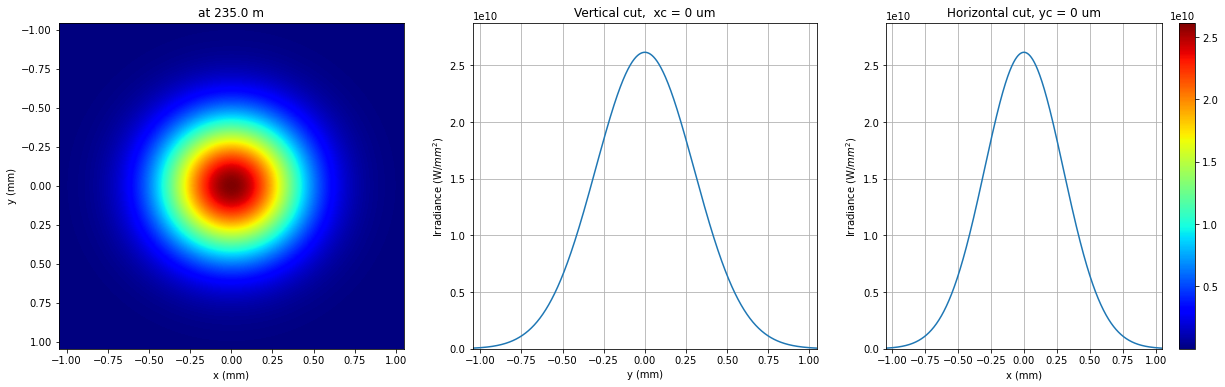

In [16]:
''' Define secondary source '''
ekev1 = ekev * (1+5e-1)
sigX1 = 12.4e-10*k/(ekev1*4*np.pi*theta_fwhm)

#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size

''' input dimensions '''
npoints=2000

wfr1 = build_gauss_wavefront_xy(npoints, npoints, ekev1, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX1, sigX1, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/np.sqrt(2),
                                repRate=1/(np.sqrt(2)*pulse_duration))

mwf1 = Wavefront(wfr1)
ip = np.floor(ekev1)
frac = np.floor((ekev1 - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname1 = 'g' + ename
ifname1 = os.path.join(strDataFolderName,fname1+'.h5')
print('save hdf5: '+fname1+'.h5')
mwf.store_hdf5(ifname1)
print('done')

mwf_backup1 = mwf1

Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 8427.5
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9479211453731577
	nvz = -0.3185051053820656
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.3185051053820656
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 1
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 0.5
	Fy = 0.5
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart

Text(0, 0.5, 'y (mm)')

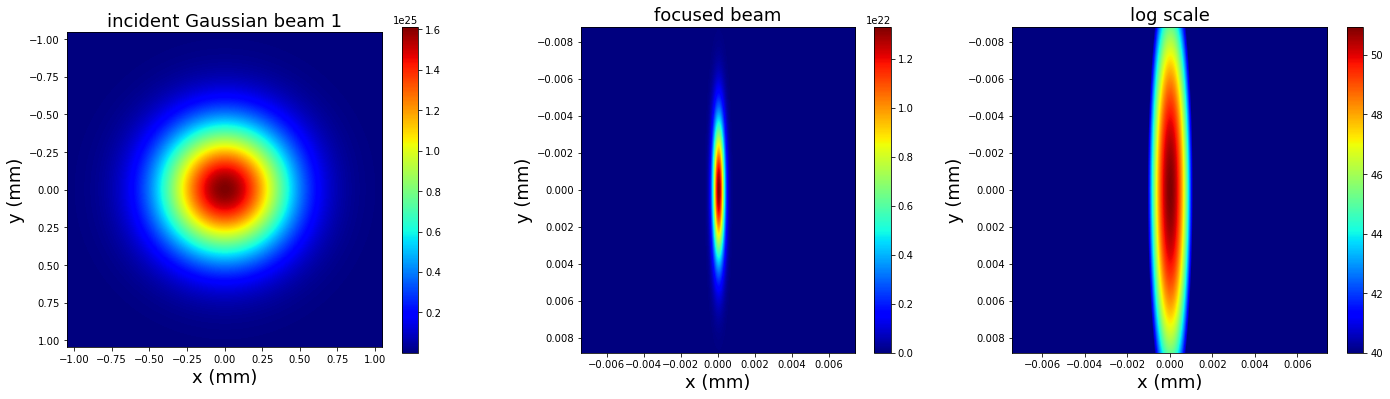

In [19]:
''' crystal parameters '''
d_sp = 3.13557135638           # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05     # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06      # imaginary part of ""
psi_hr = -2.71341902391e-05    # real part of Hth Fourier component
psi_hi = 2.50565837652e-06     # imaginary part of ""
psi_hbr = -2.71341902391e-05   # real part of -Hth Fourier component
psi_hbi = 2.50565837652e-06    # imaginary part of ""
tc = 0.01                      # crystal thickness
ang_as = -np.deg2rad(5)        # asymmetric angle
uc = 1                         # use case: 1 (Bragg reflection); 2 (Bragg transmission)
#ang = 0.83257236543
#amp_coef = 1.0

OE_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' crystal orientation '''
ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# outward normal vector to crystal surface
nvx, nvy, nvz = OE_Crystal.find_orient((ekev+ekev1)/2*1e3,ang_dif_pl)[0][2]

# central tangential vector
tvx, tvy, _ = OE_Crystal.find_orient((ekev+ekev1)/2*1e3,ang_dif_pl)[0][0]

OE_Crystal.set_orient(nvx,nvy,nvz,tvx,tvy)

''' lens parameter '''
Lens_width = 0.5e-3
f_lens = 0.5

Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=E,_eFin=E)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

''' propagation '''
z2 = 1           # propagation distance from crystal to lens
z3 = f_lens      # propagation distance from lens to focal plane

optBL4 = Beamline()
optBL4.append(OE_Crystal, Use_PP())
optBL4.append(Drift(z2),  Use_PP(semi_analytical_treatment=1))
optBL4.append(Lens_Apt,   Use_PP())
optBL4.append(Lens_Tr,    Use_PP())
optBL4.append(Drift(z3),  Use_PP(semi_analytical_treatment=1))

bl = optBL4

out_file_name = None

startTime = time.time()
mwf_crystal1 = propagate_wavefront(ifname, bl,out_file_name)
mwf_crystal2 = propagate_wavefront(ifname1,bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' plot '''
# incident beam
[xmin, xmax, ymin, ymax] = mwf_backup.get_limits()
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(mwf_backup.get_intensity(slice_number=0),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('incident Gaussian beam 1',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

# focused beam
[xmin, xmax, ymin, ymax] = mwf_crystal1.get_limits()
roi_ratio = 0.3
roixi = int(nx*(1-roi_ratio)/2); roixf = int(nx*(1+roi_ratio)/2)
roiyi = int(ny*(1-roi_ratio)/2); roiyf = int(ny*(1+roi_ratio)/2)

xlimi = xmin*roi_ratio; xlimf = xmax*roi_ratio
ylimi = ymin*roi_ratio; ylimf = ymax*roi_ratio

field_r = mwf_crystal1.get_real_part(slice_number=0) + mwf_crystal2.get_real_part(slice_number=0)
field_i = mwf_crystal1.get_imag_part(slice_number=0) + mwf_crystal2.get_imag_part(slice_number=0)

field_tot = field_r + 1j * field_i

plt.subplot(1,3,2)
plt.imshow(np.square(np.abs(field_tot))[roixi:roixf,roiyi:roiyf],cmap='jet',
          extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar()
plt.title('focused beam',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)

plt.subplot(1,3,3)
plt.imshow(
    np.log(np.square(np.abs(field_tot)))[roixi:roixf,roiyi:roiyf],cmap='jet',clim=40,
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('log scale',fontsize=18)
plt.xlabel('x (mm)',fontsize=18)
plt.ylabel('y (mm)',fontsize=18)
